# Model Performance

In [1]:
# load libraries
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
from numerapi import NumerAPI
from utils.api_keys import PUBLIC_ID, SECRET_KEY

In [2]:
# instantiate
TODAY = dt.datetime.now()
nmr = yf.download('NMR-USD', start=TODAY, end=TODAY, progress=False)
napi = NumerAPI(public_id=PUBLIC_ID, secret_key=SECRET_KEY)

In [3]:
# get model performance history
def get_model_rankings(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_model_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list)
    return df_all

# plot model rankings
def plot_model_rankings(data, after_date, cols):
    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12, 10))
    df = data.loc[data["date"] >= after_date].set_index("date")
    df.loc[df["modelName"] == "dh_foxhound", cols].plot(ax=axes[0, 0])
    df.loc[df["modelName"] == "dh_deadcell", cols].plot(ax=axes[0, 1])
    df.loc[df["modelName"] == "dh_cobra", cols].plot(ax=axes[0, 2])
    df.loc[df["modelName"] == "dh_beautybeast", cols].plot(ax=axes[1, 0])
    df.loc[df["modelName"] == "dh_skulls", cols].plot(ax=axes[1, 1])
    df.loc[df["modelName"] == "dh_desperado", cols].plot(ax=axes[1, 2])
    axes[0, 0].set_title("Foxhound")
    axes[0, 1].set_title("Deadcell")
    axes[0, 2].set_title("Cobra")
    axes[1, 0].set_title("BeautyBeast")
    axes[1, 1].set_title("Skulls")
    axes[1, 2].set_title("Desperado")
    plt.show()

# Current Staking Amount

In [4]:
# nmr price
nmr_price = nmr[['Open', 'High', 'Low', 'Close']].mean(axis=1)[0]
nmr_price

12.559526205062866

In [5]:
# get model names
model_list = napi.get_models().keys()
model_list

dict_keys(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast', 'dh_skulls', 'dh_desperado'])

In [6]:
# get current staking amount
for k in model_list:
    try:
        nmr_stake = round(float(napi.stake_get(k)), 2)
        nmr_usd = round(nmr_stake * nmr_price, 2)
        print(f"{k}: NMR{nmr_stake}, ${nmr_usd}")
    except:
        pass

dh_foxhound: NMR1.01, $12.69
dh_deadcell: NMR0.94, $11.81
dh_cobra: NMR0.0, $0.0
dh_beautybeast: NMR0.0, $0.0
dh_desperado: NMR0.0, $0.0


# Model Ranks

In [7]:
# get model rankings
perf = get_model_rankings(model_list=model_list)
perf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 11
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype                  
---  ------     --------------  -----                  
 0   corrRank   361 non-null    float64                
 1   corrRep    361 non-null    float64                
 2   date       361 non-null    datetime64[ns, tzutc()]
 3   fncRank    361 non-null    float64                
 4   fncRep     361 non-null    float64                
 5   fncV3Rank  69 non-null     float64                
 6   fncV3Rep   69 non-null     float64                
 7   mmcRank    361 non-null    float64                
 8   mmcRep     361 non-null    float64                
 9   tcRank     154 non-null    float64                
 10  tcRep      154 non-null    float64                
 11  modelName  361 non-null    object                 
dtypes: datetime64[ns, tzutc()](1), float64(10), object(1)
memory usage: 36.7+ KB


In [8]:
# date variable
AFTER_DATE = "2022-04-01"

In [9]:
# check model name list
perf["modelName"].unique()

array(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast',
       'dh_desperado'], dtype=object)

In [10]:
# cols
rank_cols = [col for col in perf.columns if col.endswith("Rank")]
rep_cols = [col for col in perf.columns if col.endswith("Rep")]

rank_cols, rep_cols

(['corrRank', 'fncRank', 'fncV3Rank', 'mmcRank', 'tcRank'],
 ['corrRep', 'fncRep', 'fncV3Rep', 'mmcRep', 'tcRep'])

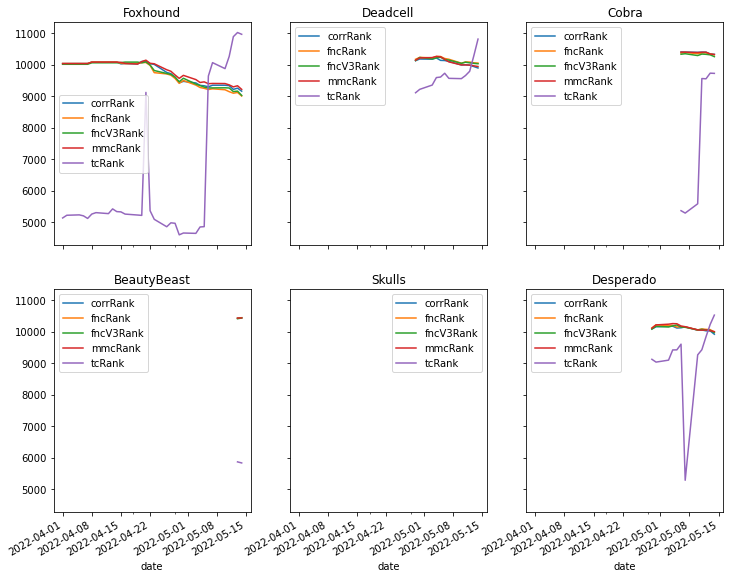

In [11]:
# plot rankings
plot_model_rankings(data=perf, after_date=AFTER_DATE, cols=rank_cols)

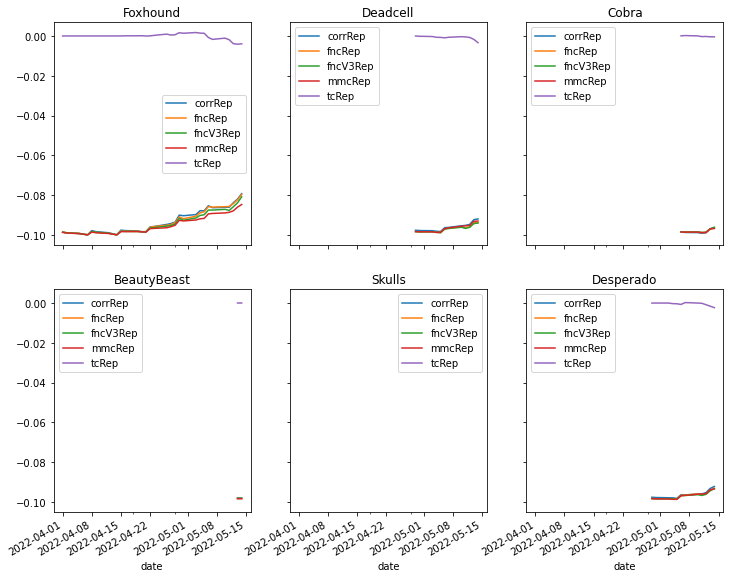

In [12]:
# plot reputations
plot_model_rankings(data=perf, after_date=AFTER_DATE, cols=rep_cols)